In [1]:
# Import modules
import numpy as np # maths

from time import time# timer for debug

    # gather results obtained from the runs
import hickle as hkl # open .pkl files where python objects have been saved
from safe import safe # the empty class which is used to save the results
    
    # system commands

import os
    
    # interact with the C++ core and the Python core
import dimers as dim # C++ interface module
import KagomeFunctions as kf # "library" allowing to work on Kagome
import KagomeDrawing as kdraw # "library" allowing to plot Kagome
import Observables as obs #observables that can be used by the run script
import KagomeFT as kft #small functions to compute the FT
import AnalysisFunctions as af # functions to make the analysis code cleaner
    #plots using matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({'font.size': 14, 'pgf.texsystem':'pdflatex'})

In [2]:
# Create a folder to save the pictures
foldername = '../Analysis_PSI/TheoreticalStructureFactors/Runs_04-02-20_StrctFact/KJ1h_L12_nsm16384_folder/'
results_foldername = '12-02-2020/'
os.makedirs('./' + foldername + 'Plots' + results_foldername, exist_ok = True)

filenamelist = ['backup']
n = len(filenamelist)

In [3]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, temperatures,
 nt, stat_temps, temperatures_plots, hfields, nh, stat_hfields,
 hfields_plots, listfunctions, sref] = af.LoadParameters(foldername, filenamelist)

In [4]:
kw = {'binning':False, 'plzplot': False,
      'plotmin': 0, 'plotmax': 20}

In [5]:
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites, nb,
               stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)

In [6]:
[t_h_MeanM, t_h_MeanMsq, t_h_varMeanM, t_h_varMeanMsq, Chi, ErrChi] = \
 af.LoadMagnetisation(foldername, filenamelist, numsites, nb,
                      stat_temps, temperatures, stat_hfields,listfunctions, **kw)

In [7]:
t_h_MeanSs, t_h_varMeanSs, t_h_MeanSi, t_h_varMeanSi, t_h_MeanCorr, t_h_errCorrEstim = \
 af.LoadCentralCorrelations(foldername, filenamelist, listfunctions, sref, stat_temps[0:4], stat_hfields, nb, **kw)


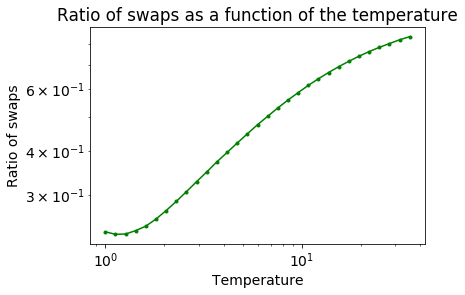

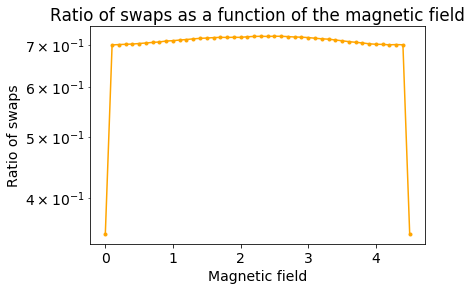

In [8]:
###########################################
        ## ALGORITHM ANALYSIS ##
###########################################
tidmin = 0
tidmax = nt
swapst_th, swapsh_th, swapst, swapsh = af.LoadSwaps(foldername, filenamelist, nb, num_in_bin, nh, nt)
af.SwapsAnalysis(L, n, tidmin, tidmax, temperatures, hfields, foldername, results_foldername, swapst, swapsh)

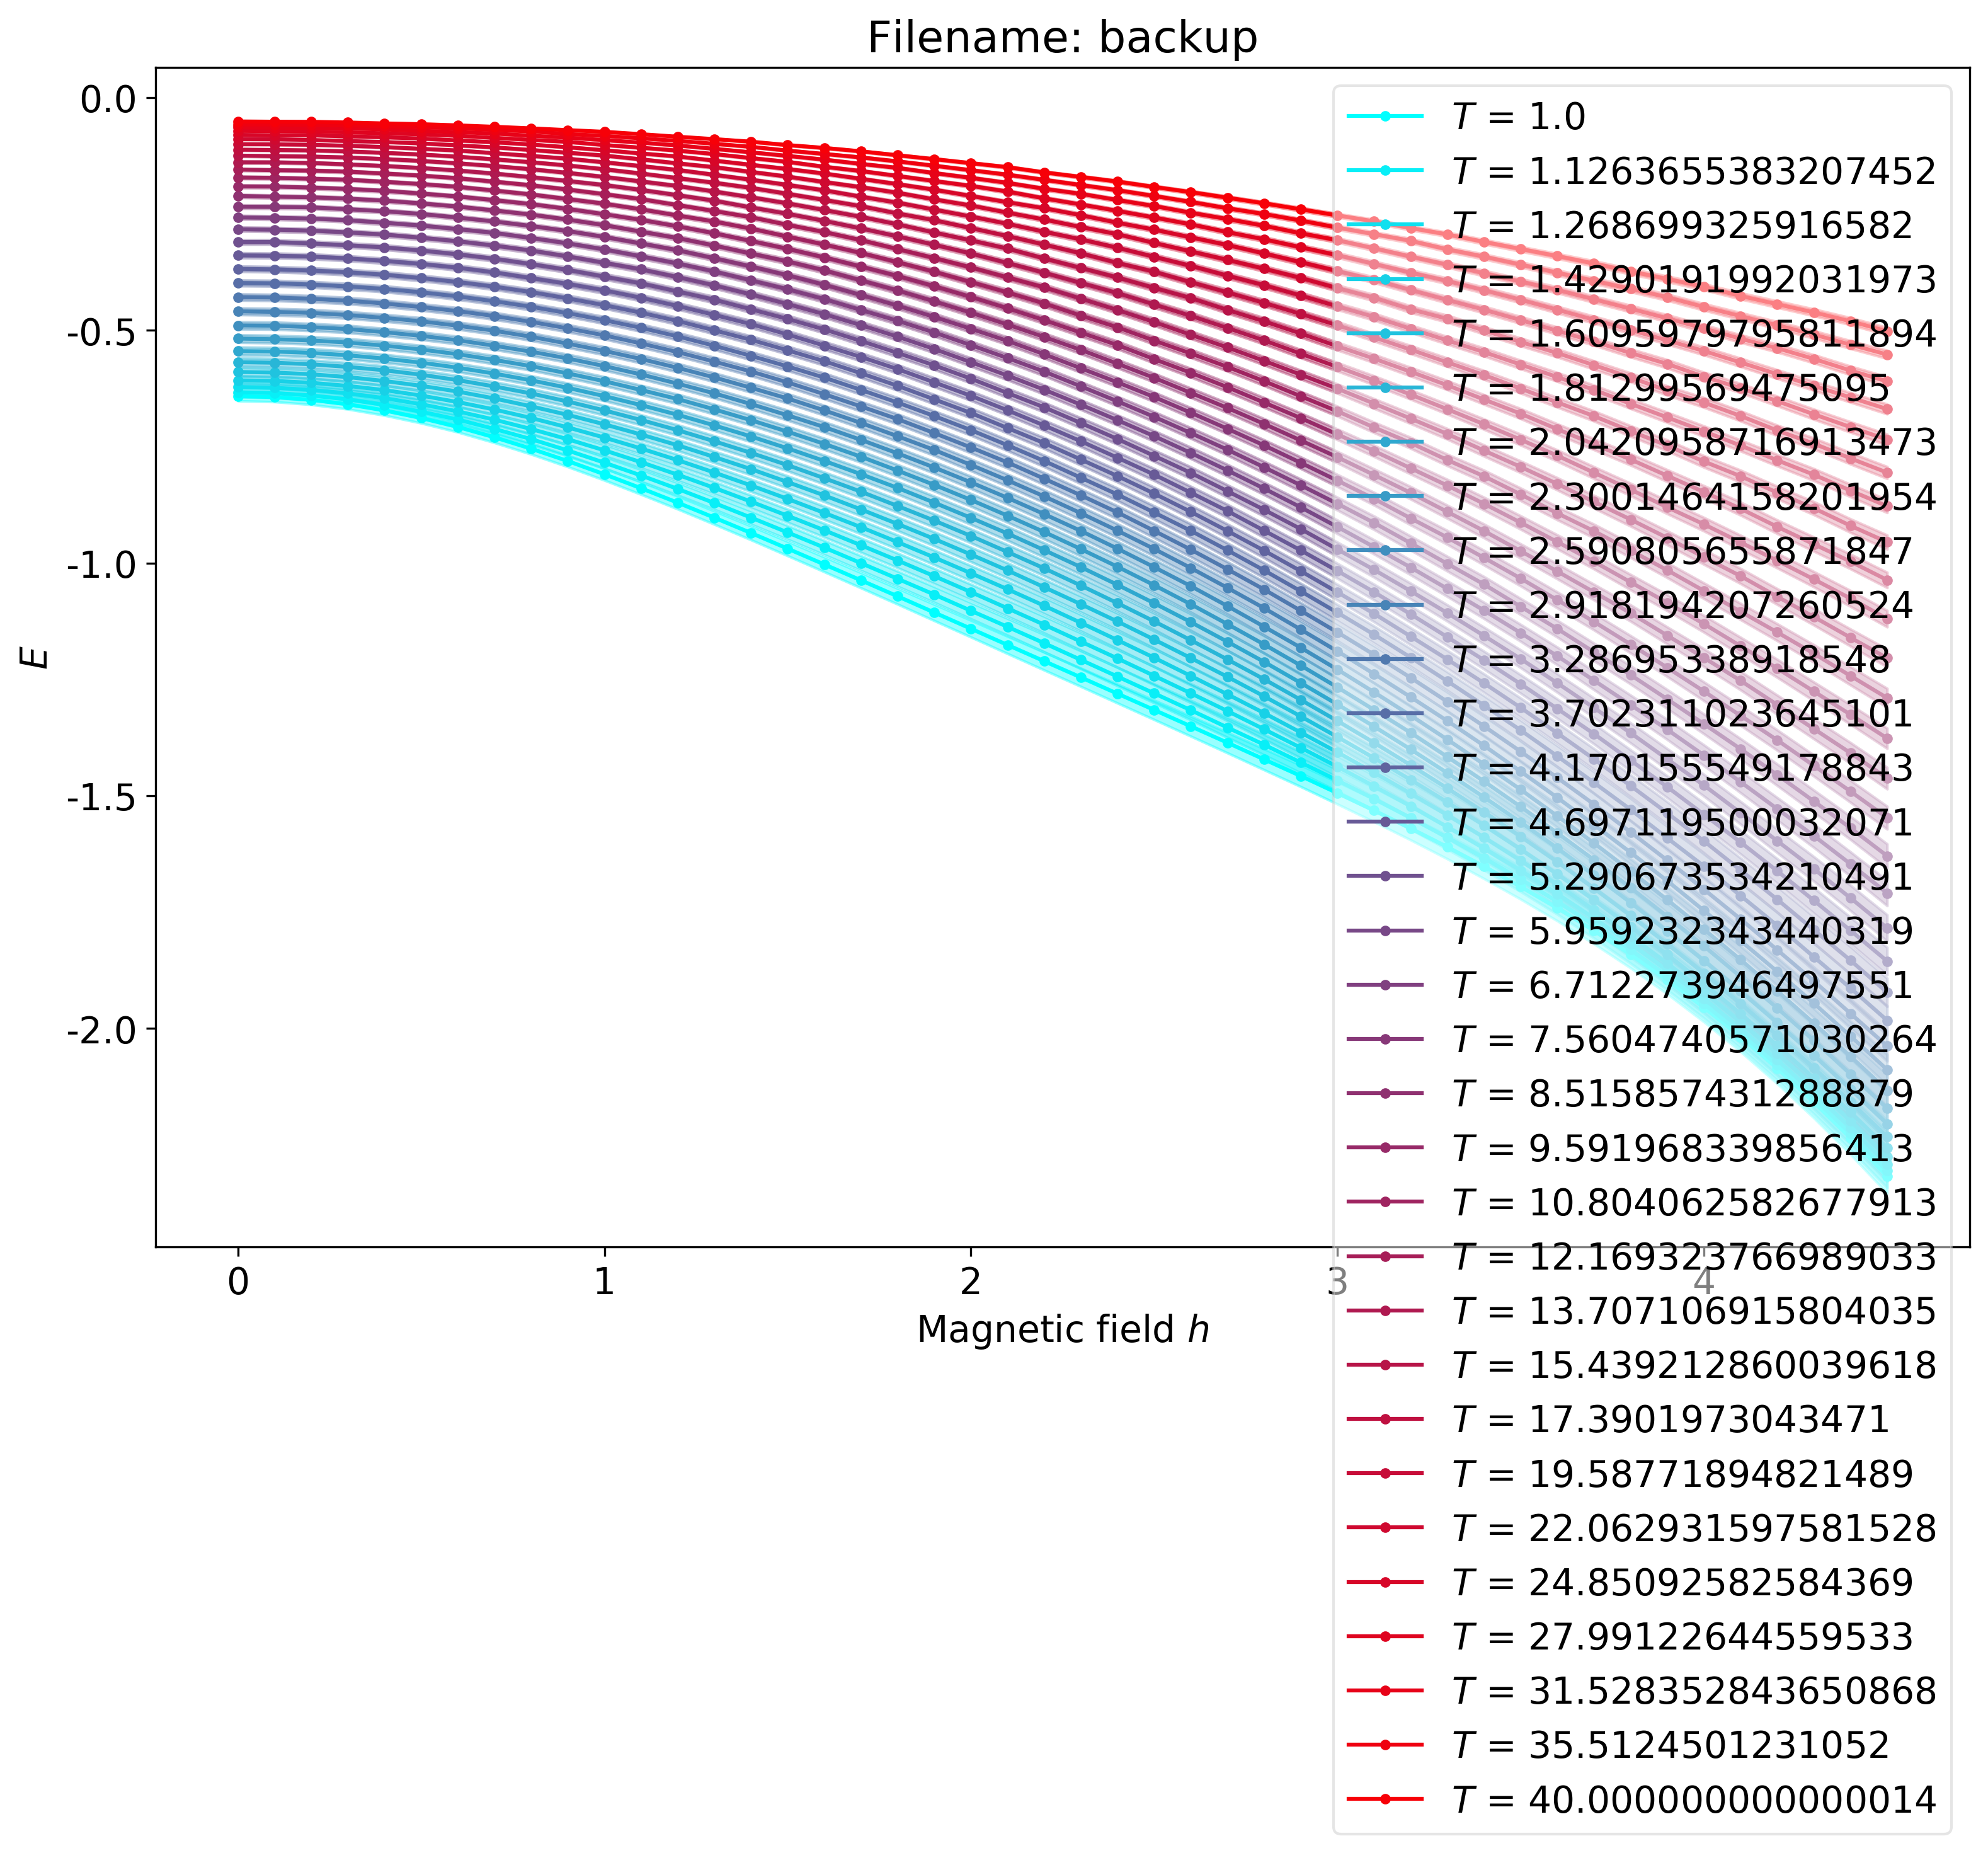

In [9]:
###########################################
        ## STATISTICS ANALYSIS ##
###########################################
tidmin = 0
tidmax = [len(stat_temps[i]) for i in range(n)]
temperatures_plots = np.array(temperatures_plots)
if nh > nt:
    ploth = True
else:
    ploth = False
### Energy
kwargs = {'RS':True, 'ploth': ploth}
af.BasicPlotsE(L, n, tidmin, tidmax, temperatures_plots, hfields_plots,
               foldername, results_foldername, filenamelist, t_h_MeanE,
               t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC, J1, J2, J3, J4, **kwargs)


In [ ]:
### Magnetisation
af.BasicPlotsM(L, n, tidmin, tidmax, temperatures_plots, hfields_plots,
               foldername, results_foldername, filenamelist, t_h_MeanM,
               t_h_MeanMsq, t_h_varMeanM, t_h_varMeanMsq, Chi, ErrChi,
               J1, J2, J3, J4, **kwargs)

In [ ]:
# Check correlations
t_h_MeanSisq1 = []
t_h_MeanSifile = np.copy(t_h_MeanSi[0])
for i in range(len(sref[0])):
        column = t_h_MeanSifile[:, :, sref[0][i]]
        column = column[:,:,np.newaxis]
        t_h_MeanSisq1.append(t_h_MeanSifile*column)

t_h_MeanSisq2 = [] 
t_h_MeanCorrCheck = [np.copy(t_h_MeanSs[0][:,:,i,:]) for i in range(len(sref[0]))]
for i in range(len(sref[0])):
    t_h_MeanSisq2.append(np.zeros(t_h_MeanSs[0][:,:,i,:].shape))
    for sid in range(9*L[0]**2):
        x = t_h_MeanSifile[:,:,sref[0][i]]*t_h_MeanSifile[:,:,sid]
        t_h_MeanCorrCheck[i][:,:,sid] += -x
        t_h_MeanSisq2[i][:,:,sid] = x
for srefid in range(3):
    print("Correlations difference",
          np.amax(t_h_MeanCorrCheck[srefid]-t_h_MeanCorr[0][srefid]))
    print("Si expectation value difference",
          np.amax(t_h_MeanSisq1[srefid]-t_h_MeanSisq2[srefid]))

In [ ]:
### COMPUTING CORRELATIONS FROM <SISJ> AND <SI> and plotting in 2D
if not ploth:
    tid = 1
    hid = 1
    rid = tid
else:
    tid = 9
    hid = 15
    rid = hid

[corr, errcorr, maxerr] = af.PrepPlot2DCorrelations(rid, n, 
                                                t_h_MeanCorr,
                                                t_h_errCorrEstim,
                                                t_h_MeanSi,
                                                hfields_plots,
                                                temperatures_plots,\
                                                ploth = ploth)
print("t = ",temperatures_plots[0][tid])
print("h = ",hfields_plots[0][hid])

In [ ]:
af.BasicPlotsCorrelations2D(foldername, results_foldername, rid,
                            n,L,corr,errcorr,
                            t_h_MeanSi, hfields_plots, 
                            temperatures_plots,
                            ploth = ploth)

In [ ]:
# Check structure factor:
testMeanCorr = [np.zeros(t_h_MeanCorr[0].shape)]
testMeanCorr[0][0, :,:,sref[0][0]] = 1
testMeanCorr[0][1, :,:,sref[0][1]] = 1
testMeanCorr[0][2, :,:,sref[0][2]] = 1
StrctFact =\
kft.StrctFact(L[0],
              np.array(testMeanCorr[0])[:,tid,hid,:],\
              centered = True, srefs = sref[0])
af.PlotStrctFact(StrctFact, foldername, results_foldername, tid,
                 hid, L, 0, hfields_plots, temperatures_plots, 
                 vmindiag = 0.4, vmaxdiag = 1.6, vminoff = -0.6, vmaxoff = 0.6)

In [ ]:
## COMPUTE AND PLOT STRUCTURE FACTORS
i = 0

StrctFact =\
kft.StrctFact(L[i],
              np.array(t_h_MeanCorr[i])[:,tid,hid,:],\
              centered = True, srefs = sref[i])
vmin = 1.5
vmax = 2.5

af.PlotStrctFact(StrctFact, foldername, results_foldername, tid,
                 hid, L, i, hfields_plots, temperatures_plots,
                 vmindiag = 0.4, vmaxdiag = 1.6,vminoff = -0.6, vmaxoff = 0.6)

In [ ]:
af.PlotFirstCorrelations(n, L,foldername, results_foldername,  hfields_plots, temperatures_plots,
                         t_h_MeanCorr, t_h_errCorrEstim,\
                         distmax = 2, ploth = ploth)

In [ ]:
############ OLD CODE ################

In [ ]:
#def dist_lincorr(L,findex, corr, errf,distmax):
#    distances, distances_spins, NNList, s_pos, srefs = kf.NearestNeighboursLists(L, distmax)
#    rdistances = []
#    C = [[0 for i in range(len(NNList[0]))] for j in range(len(srefs))]
#    ErrC = [[0 for i in range(len(NNList[0]))] for j in range(len(srefs))]
#    for j in range(len(srefs)):
#        ci = 0
#        for i in range(len(NNList[0])):
#            #if i == 0 or i == 2 or i == 5 or i == 9:
#                Corrji = 0
#                ErrCorrji = 0
#                count = 0
#                for pair in NNList[j][i]:
#                    if srefs[j] == pair[0]:
#                        count += 1
#                        Corrji += corr[findex][j][pair[1]]
#                        ErrCorrji += errf[findex][j][pair[1]]
#                if count == 0:
#                    print("Warning, sthg weird with count")
#                    count = 1
#                Corrji = Corrji/count
#                ErrCorrji = ErrCorrji/count
#
#
#                C[j][ci] = Corrji
#                ErrC[j][ci]= ErrCorrji
#                ci = ci+1
#                rdistances.append(distances[i])
#        C[j] = np.array(C[j])
#        ErrC[j] = np.array(ErrC[j])
#
#    C = np.array(sum(C))/3
#    ErrC = np.array(sum(ErrC))/3
#    return rdistances, C, ErrC

In [ ]:
## PLOT RADIAL DEPENDENCE OF THE CORRELATIONS (AND SPOTTING THE FIRST SEVEN SITES)
#minr = []
#maxr = []
#
#rpos = [[] for _ in range(n)]
#corrpos = [[] for _ in range(n)]
#errcorrpos = [[] for _ in range(n)]
#
#rneg = [[] for _ in range(n)]
#corrneg = [[] for _ in range(n)]
#errcorrneg = [[] for _ in range(n)]
#
#rtot = [[] for _ in range(n)]
#corrtot = [[] for _ in range(n)]
#errcorrtot = [[] for _ in range(n)]
#
#firstfewposlist = []
#distmax = 6
#
#resrlist = [[] for _ in range(n)]
#for i in range(n):
#    distmin = 0.5
#    (resr, rescorr, reserrcorr) = dist_lincorr(L[i], i ,corr, errcorr, distmax)
#    #firstfewposlist.append(firstfewpos)
#    #print(rescorr)
#    print(rescorr)
#    resrlist[i] = resr
#    for index, correl in enumerate(rescorr):
#        if correl >= 0:
#            rpos[i].append(resr[index])
#            rtot[i].append(resr[index])
#            corrpos[i].append(correl)
#            corrtot[i].append(correl)
#            errcorrpos[i].append(reserrcorr[index])
#            errcorrtot[i].append(reserrcorr[index])
#        else:
#            rneg[i].append(resr[index])
#            rtot[i].append(resr[index])
#            corrneg[i].append(-correl)
#            corrtot[i].append(-correl)
#            errcorrneg[i].append(reserrcorr[index])
#            errcorrtot[i].append(reserrcorr[index])
#
#    rpos[i] = np.array(rpos[i])
#    rneg[i] = np.array(rneg[i])
#    rtot[i] = np.array(rtot[i])
#    minr.append(min(rtot[i]))
#    maxr.append(max(rtot[i]))
#    corrpos[i] = np.array(corrpos[i])
#    corrneg[i] = np.array(corrneg[i])
#    corrtot[i] = np.array(corrtot[i])
#    errcorrpos[i] = np.array(errcorrpos[i])
#    errcorrneg[i] = np.array(errcorrneg[i])
#    errcorrtot[i] = np.array(errcorrtot[i])
#    
#    #fig = plt.figure()
#    #ax = fig.add_subplot(111)
#    fig, ax = plt.subplots(dpi=200) # short for the above
#    ax.set_yscale("log", nonposy='clip')
#    #plt.semilogy(rpos[i], corrpos[i], '.')
#    plt.errorbar(rpos[i], corrpos[i], yerr=errcorrpos[i], fmt = '.')
#    plt.hlines([maxerr[i]], minr[i], maxr[i])
#    plt.xlabel(r'$r$')
#    plt.ylabel(r'$<\sigma_i \sigma_j>(r) - <\sigma_i> <\sigma_j>(r) $ (logscale)')
#    plt.title('Correlations L={0}'.format(L[i]))
#    plt.savefig('./' + foldername + 'Plots' + results_foldername+ '/Correlations_Pos_L={0}_various-nsms.png'.format(L[i]))
#    
#    fig, ax = plt.subplots(dpi=200) # short for the above
#    ax.set_yscale("log", nonposy='clip')
#    #plt.semilogy(rpos[i], corrpos[i], '.')
#    plt.errorbar(rneg[i], corrneg[i], yerr=errcorrneg[i], fmt = '.')
#    plt.hlines([maxerr[i]], minr[i],maxr[i])
#    plt.xlabel(r'$r$')
#    plt.ylabel(r'$<\sigma_i \sigma_j>(r) - <\sigma_i> <\sigma_j>(r) $ (logscale)')
#    plt.title('Correlations L={0}'.format(L[i]))
#    plt.savefig('./' + foldername + 'Plots' + results_foldername+ '/Correlations_Neg_L={0}_various-nsms.png'.format(L[i]))
#    
#    fig, ax = plt.subplots(dpi=200, figsize = (9,6)) # short for the above
#    ax.set_yscale("log", nonposy='clip')
#    plt.errorbar(rneg[i], corrneg[i], yerr=errcorrneg[i], fmt = '.', color = 'red')
#    plt.errorbar(rpos[i], corrpos[i], yerr=errcorrpos[i], fmt = '.', color = 'blue')
#    plt.hlines([maxerr[i]], minr[i],maxr[i])
#    plt.xlabel(r'$r$')
#    plt.ylabel(r'$<\sigma_i \sigma_j>(r) - <\sigma_i> <\sigma_j>(r) $ (logscale)')
#    plt.title('Correlations L={0}'.format(L[i]))
#    plt.savefig('./' + foldername + 'Plots' + results_foldername+ '/Correlations_L={0}_various-nsms.png'.format(L[i]))
##print(errcorrneg[i])

In [ ]:
#fig, ax = plt.subplots(dpi=200)
#for i in range(n): 
#    ax.set_yscale("log", nonposy='clip')
#    plt.errorbar(rtot[i], corrtot[i], yerr=errcorrtot[i], fmt = '.', color = 'red')
#    plt.hlines([maxerr[i]], minr[i],maxr[i])
#    
#print(corrtot[i])
#print(errcorrtot[i])
#plt.xlabel(r'$r$')
#plt.ylabel(r'$<\sigma_i \sigma_j>(r) - <\sigma_i> <\sigma_j>(r) $ (logscale)')
#plt.title('Correlations L={0}'.format(L[i]))
#plt.savefig('./' + foldername + 'Plots' + results_foldername+ '/Correlations_L={0}_various-nsms_semilogy.png'.format(L[i]))

In [ ]:
#### FITING
#def algebraic(x, a, eta):
#    return a / (x ** eta)
#def expfunc(x, a, b):
#    return a * np.exp(-b * x)

In [ ]:
#from scipy.optimize import curve_fit
#
#poptalgpos = [[] for _ in range(n)]
#pcovalgpos = [[] for _ in range(n)]
#
#poptalgneg = [[] for _ in range(n)]
#pcovalgneg = [[] for _ in range(n)]
#
#poptexppos = [[] for _ in range(n)]
#pcovexppos = [[] for _ in range(n)]
#
#poptexpneg = [[] for _ in range(n)]
#pcovexpneg = [[] for _ in range(n)]
#
#poptexp = [[] for _ in range(n)]
#pcovexp = [[] for _ in range(n)]
#
#rposmax = 25
#rnegmax = 25
#rtotmax = 50
#for i in range(0, n,1):
#    print(i)
#    
#    poptalgpos[i], pcovalgpos[i] = curve_fit(algebraic, rpos[i][1:rposmax], corrpos[i][1:rposmax], bounds = (0, [2., 10]))
#    poptalgneg[i], pcovalgneg[i] = curve_fit(algebraic, rneg[i][1:rnegmax], corrneg[i][1:rnegmax], bounds = (0, [2., 10]))
#    
#    print(i, 'alg')
#    
#    poptexppos[i], pcovexppos[i] = curve_fit(expfunc, rpos[i][0:rposmax], corrpos[i][0:rposmax], bounds = (0, [2., 4.]))
#    poptexpneg[i], pcovexpneg[i] = curve_fit(expfunc, rneg[i][0:rnegmax], corrneg[i][0:rnegmax], bounds = (0, [2., 4.]))
#    poptexp[i], pcovexp[i] = curve_fit(expfunc, rtot[i][0:rtotmax], corrtot[i][0:rtotmax], bounds=(0, [2., 4.]))
#    print(i, 'exp')
#
#    plt.figure(dpi=200)
#    plt.loglog(rpos[i][1:rposmax], corrpos[i][1:rposmax], '.')
#    plt.loglog(rpos[i][1:rposmax], algebraic(rpos[i][1:rposmax], *poptalgpos[i]), 'b-', label='fit: a=%5.3f, eta=%5.3f' % tuple(poptalgpos[i]))
#    plt.loglog(rneg[i][1:rnegmax], corrneg[i][1:rnegmax], '.', color='red')
#    plt.loglog(rneg[i][1:rnegmax], algebraic(rneg[i][1:rnegmax], *poptalgneg[i]), 'r-', label='fit: a=%5.3f, eta=%5.3f' % tuple(poptalgneg[i])) 
#    plt.xlabel(r'$r$')
#    plt.ylabel(r'$<\sigma_i \sigma_j>(r) - <\sigma_i> <\sigma_j>(r) $')
#    plt.legend()
#    plt.title('Correlations L={0} and algebraic fit'.format(L[i]))
#    plt.savefig('./' + foldername + 'Plots' + results_foldername+ '/Correlations_AndAlgFit_L={0}_distmin=05_various-nsms.png'.format(L[i]))
#    plt.show()
#   
#    print(errcorrpos[i])
#    fig, ax = plt.subplots(dpi=200, figsize = (9,6))
#    ax.set_yscale("log")#, nonposy='clip')
#    plt.errorbar(rpos[i], corrpos[i], yerr=errcorrpos[i], fmt= '.')
#    plt.errorbar(rneg[i], corrneg[i], yerr=errcorrneg[i], fmt ='.', color='red')
#    plt.plot(rpos[i][0:rposmax], expfunc(rpos[i][0:rposmax], *poptexppos[i]), 'b-', label='fit: a=%5.3f, b=%5.3f' % tuple(poptexppos[i]))
#    plt.plot(rneg[i][0:rnegmax], expfunc(rneg[i][0:rnegmax], *poptexpneg[i]), 'r-', label='fit: a=%5.3f, b=%5.3f' % tuple(poptexpneg[i]))
#    plt.plot(rtot[i][0:rtotmax], expfunc(rtot[i][0:rtotmax], *poptexp[i]), 'k-', label='fit: a=%5.3f, b=%5.3f' % tuple(poptexp[i]))
#    plt.xlabel(r'$r$')
#    plt.ylabel(r'$<\sigma_i \sigma_j>(r) - <\sigma_i> <\sigma_j>(r) $')
#    plt.legend()
#    plt.title('Correlations L={0} and exp fit'.format(L[i]))
#    plt.savefig('./' + foldername + 'Plots' + results_foldername+ '/Correlations_semilogy_AndexpFit_L={0}_distmin=05_various-nsms.png'.format(L[i]))
#    #